In [ ]:
import dataclasses
import itertools
import json
import os
import time
from functools import partial
from typing import NamedTuple

import jax
import numpy as np
import tensorflow_probability.substrates.jax as tfp
from jax import numpy as jnp
from jaxns import Prior, Model

from dsa2000_cal.solvers.multi_step_lm import MultiStepLevenbergMarquardt
from dsa2000_common.common.jax_utils import block_until_ready
from dsa2000_common.common.types import FloatArray

# jax.config.update("jax_explain_cache_misses", True)

tfpd = tfp.distributions


class CalibrationParams(NamedTuple):
    # Improvement threshold
    p_any_improvement: FloatArray = 0.1  # p0 > 0
    p_less_newton: FloatArray = 0.25  # p2 -- less than sufficient improvement
    p_sufficient_improvement: FloatArray = 0.5  # p1 > p0
    p_more_newton: FloatArray = 0.75  # p3 -- more than sufficient improvement

    # Damping alteration factors 0 < c_more_newton < 1 < c_less_newton
    c_more_newton: FloatArray = 0.1
    c_less_newton: FloatArray = 2.
    # Damping factor = mu1 * ||F(x)||^delta, 1 <= delta <= 2
    delta: FloatArray = 2
    # mu1 > mu_min > 0
    mu1: FloatArray = 1.
    mu_min: FloatArray = 1e-3


@dataclasses.dataclass(eq=False)
class ForwardModel:
    ant: int
    source: int
    chan: int

    @property
    def gain_shape(self):
        return (self.source, self.ant, self.chan)

    def create_forward_data(self):
        antenna1, antenna2 = jnp.asarray(list(itertools.combinations_with_replacement(range(self.ant), 2)),
                                         dtype=jnp.int32).T
        row = len(antenna1)
        vis_per_source = jnp.ones((self.source, row, self.chan), jnp.complex64)
        return antenna1, antenna2, vis_per_source

    def forward(self, gains, antenna1, antenna2, vis_per_source):
        g1 = gains[:, antenna1, :]  # (row, source, chan)
        g2 = gains[:, antenna2, :]
        vis = jnp.sum(g1 * vis_per_source * g2.conj(), axis=0)
        return vis


@dataclasses.dataclass(eq=False)
class OptimisationProblem:
    forward_model: ForwardModel
    num_iterations: int
    num_approx_steps: int

    def create_data(self, key, data_noise_scale: jax.Array, phase_error_scale: jax.Array, gain_noise_scale: jax.Array):
        keys = jax.random.split(key, 5)
        # Create true gains
        phases = phase_error_scale * jax.random.normal(
            keys[0],
            self.forward_model.gain_shape
        )
        gains_true = jnp.exp(1j * phases)
        gains_noise = gain_noise_scale * jax.lax.complex(
            jax.random.normal(keys[1], self.forward_model.gain_shape),
            jax.random.normal(keys[2], self.forward_model.gain_shape)
        )

        gains_true += gains_noise

        antenna1, antenna2, vis_per_source = self.forward_model.create_forward_data()

        data = self.forward_model.forward(gains_true, antenna1, antenna2, vis_per_source)
        noise = data_noise_scale * jax.lax.complex(
            jax.random.normal(keys[3], data.shape),
            jax.random.normal(keys[4], data.shape)
        )

        data += noise
        return gains_true, data, (antenna1, antenna2, vis_per_source)

    # @partial(jax.jit, static_argnums=(0,))
    def multi_step_lm_solve(self, data, forward_args, params: CalibrationParams):
        def residuals(gains):
            residuals = data - self.forward_model.forward(gains, *forward_args)
            return residuals

        x = jnp.ones(self.forward_model.gain_shape, jnp.complex64)

        lm = MultiStepLevenbergMarquardt(
            residual_fn=residuals,
            num_iterations=self.num_iterations,
            num_approx_steps=self.num_approx_steps,
            p_any_improvement=params.p_any_improvement,
            p_less_newton=params.p_less_newton,
            p_sufficient_improvement=params.p_sufficient_improvement,
            p_more_newton=params.p_more_newton,
            c_more_newton=params.c_more_newton,
            c_less_newton=params.c_less_newton,
            delta=params.delta,
            mu1=params.mu1,
            mu_min=params.mu_min,
            verbose=False
        )
        state = lm.create_initial_state(x)
        state, diagnostics = lm.solve(state)
        return diagnostics.error[-1]

    def run(self, key, data, forward_args, num_search):
        def prior_model():
            p_any_improvement = yield Prior(
                tfpd.Uniform(low=0.0, high=1.),
                name='p_any_improvement'
            )
            p_less_newton = yield Prior(
                tfpd.Uniform(low=p_any_improvement, high=1.),
                name='p_less_newton'
            )
            p_sufficient_improvement = yield Prior(
                tfpd.Uniform(low=p_less_newton, high=1.),
                name='p_sufficient_improvement'
            )
            p_more_newton = yield Prior(
                tfpd.Uniform(low=p_sufficient_improvement, high=1.),
                name='p_more_newton'
            )
            c_more_newton = yield Prior(
                tfpd.Uniform(low=0.0, high=1.),
                name='c_more_newton'
            )
            c_less_newton = yield Prior(
                tfpd.Uniform(low=1., high=5.),
                name='c_less_newton'
            )
            delta = yield Prior(
                tfpd.Uniform(low=1., high=2.),
                name='delta'
            )

            mu_min = yield Prior(
                tfpd.Uniform(low=1e-5, high=1.),
                name='mu_min'
            )
            mu1 = yield Prior(
                tfpd.Uniform(low=mu_min, high=10.),
                name='mu1'
            )
            return CalibrationParams(
                p_any_improvement=p_any_improvement,
                p_less_newton=p_less_newton,
                p_sufficient_improvement=p_sufficient_improvement,
                p_more_newton=p_more_newton,
                c_more_newton=c_more_newton,
                c_less_newton=c_less_newton,
                delta=delta,
                mu1=mu1,
                mu_min=mu_min
            )

        def log_likelihood(params: CalibrationParams):
            return -self.multi_step_lm_solve(data, forward_args, params)

        model = Model(
            prior_model=prior_model,
            log_likelihood=log_likelihood
        )

        # brute-force check
        def body(state, key):
            U = model.sample_U(key)
            X = model.transform(U)
            log_likelihood = model.forward(U)
            return state, (U, X, log_likelihood)

        _, (U, X, log_likelihoods) = jax.lax.scan(body, None, jax.random.split(key, num_search))

        return U, X, log_likelihoods



In [ ]:
forward_model = ForwardModel(ant=2048, source=1, chan=1)



In [3]:
# key = jax.random.PRNGKey(0)
# t0 = time.time()
# run_jit = jax.jit(partial(run, num_search=1000)).lower(key, data, forward_args).compile()
# build_time = time.time() - t0
# print(f"Build time: {build_time}")
# t0 = time.time()
# U, X, log_L = block_until_ready(run_jit(key, data, forward_args))
# run_time = time.time() - t0
# print(f"Run time: {run_time}")

In [7]:
from concurrent.futures import ThreadPoolExecutor


# Split workload and run in parallel using ThreadPoolExecutor
def parallel_run(num_iterations, num_approx_steps,
                 data_noise_scale,
                 phase_error_scale,
                 gain_noise_scale,
                 key, total_search,
                 num_threads):
    file_name = f"calibration_optimisation_{num_iterations}_{num_approx_steps}_{data_noise_scale:.1e}_{phase_error_scale:.1e}_{gain_noise_scale:.1e}.json"
    if os.path.exists(file_name):
        print(f"File {file_name} already, skipping")
        return
    optimisation_problem = OptimisationProblem(
        forward_model=forward_model,
        num_iterations=num_iterations,
        num_approx_steps=num_approx_steps
    )

    gains_true, data, forward_args = optimisation_problem.create_data(
        jax.random.PRNGKey(0),
        data_noise_scale,
        phase_error_scale,
        gain_noise_scale
    )

    def run_parallel(key, data, forward_args, num_search):
        # Define the function to execute in each thread
        run_jit = jax.jit(partial(optimisation_problem.run, num_search=num_search)).lower(key, data,
                                                                                          forward_args).compile()
        U, X, log_L = block_until_ready(run_jit(key, data, forward_args))
        return U, X, log_L

    keys = jax.random.split(key, num_threads)  # Split PRNG keys for parallel processing
    partial_num_search = total_search // num_threads  # Divide workload
    t0 = time.time()
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(run_parallel, keys[i], data, forward_args, partial_num_search)
            for i in range(num_threads)
        ]

    # Collect the results once all threads are done

    results = [future.result() for future in futures]
    run_time = time.time() - t0
    print(f"num_iterations={num_iterations}, num_approx_steps={num_approx_steps}, "
          f"data_noise_scale={data_noise_scale:.1e}, phase_error_scale={phase_error_scale:.1e}, "
          f"gain_noise_scale={gain_noise_scale:.1e}, run_time={run_time} s")

    U = jnp.concatenate([results[i][0] for i in range(num_threads)], axis=0)
    X = []
    for i in range(num_threads):
        X.append(results[i][1])
    X = jax.tree.map(lambda *arrays: jnp.concatenate(arrays, axis=0), *X)
    log_L = jnp.concatenate([results[i][2] for i in range(num_threads)], axis=0)

    data_dict = dict(
        num_iterations=num_iterations,
        num_approx_steps=num_approx_steps,
        data_noise_scale=float(data_noise_scale),
        phase_error_scale=float(phase_error_scale),
        gain_noise_scale=float(gain_noise_scale),
        U=U.tolist(),
        X=jax.tree.map(lambda x: x.tolist(), X),
        log_L=log_L.tolist(),
        run_time=run_time
    )
    with open(file_name, 'w') as f:
        json.dump(data_dict, f, indent=2)

    return U, X, log_L

In [15]:
key = jax.random.PRNGKey(0)

sol_int_size = 40 * 4

for num_iterations, num_approx_steps in [(1, 0), (1, 1), (1, 2),
                                         (1, 4), (2, 2), (1, 6),
                                         (4, 1), (3, 2), (5, 1)]:
    for data_noise_scale in [8.04, 8.04 / np.sqrt(sol_int_size)]:  # 8.04 Jy
        for phase_error_scale in [0.1, 1.0]:
            for gain_noise_scale in [0.1]:
                U, X, log_L = parallel_run(num_iterations, num_approx_steps, data_noise_scale, phase_error_scale,
                                           gain_noise_scale, key, 1024, os.cpu_count())


KeyboardInterrupt: 

In [13]:
def plot(num_iterations, num_approx_steps, data_noise_scale, phase_error_scale, gain_noise_scale):
    file_name = f"calibration_optimisation_{num_iterations}_{num_approx_steps}_{data_noise_scale:.1e}_{phase_error_scale:.1e}_{gain_noise_scale:.1e}.json"

    with open(file_name, 'r') as f:
        data_dict = json.load(f)
        num_iterations = data_dict['num_iterations']
        num_approx_steps = data_dict['num_approx_steps']
        data_noise_scale = jnp.asarray(data_dict['data_noise_scale'])
        phase_error_scale = jnp.asarray(data_dict['phase_error_scale'])
        gain_noise_scale = jnp.asarray(data_dict['gain_noise_scale'])
        U = jnp.asarray(data_dict['U'])
        X = dict((key, jnp.asarray(values)) for key, values in data_dict['X'].items())
        log_L = jnp.asarray(data_dict['log_L'])
        run_time = data_dict['run_time']

    # Get cumulative best log likelihood in search
    best_log_L = jax.lax.cummax(log_L, axis=0)

    import pylab as plt

    plt.plot(jnp.log(-best_log_L))
    plt.xlabel('Search iteration')
    plt.ylabel('Best negative log likelihood')
    plt.title('Calibration Parameter Optimisation Progress')
    plt.savefig(
        f"calibration_optimisation_progress_{num_iterations}_{num_approx_steps}_{data_noise_scale:.1e}_{phase_error_scale:.1e}_{gain_noise_scale:.1e}.png")
    plt.show()

    # A corner plot of the parameter space
    labels = sorted(X.keys())

    objective = -log_L
    # Sort by increasing objective so that plotting happens in order
    sort_idx = jnp.argsort(objective)[::-1]
    X = jax.tree.map(lambda x: x[sort_idx], X)
    objective = objective[sort_idx]
    fig, axs = plt.subplots(len(labels), len(labels), figsize=(10, 10))
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if j > i:
                axs[i, j].axis('off')
                continue

            if i == j:
                axs[i, j].hist(X[label1], bins='auto')
            else:
                sc = axs[i, j].scatter(X[label2], X[label1], s=1, c=objective, cmap='jet')

            if i == len(labels) - 1:
                axs[i, j].set_xlabel(label2, rotation=45, ha='right')
            if j == 0:
                axs[i, j].set_ylabel(label1, rotation=45, ha='right')

            # Turn off x-axis labels for all but bottom row
            if i < len(labels) - 1:
                axs[i, j].set_xticklabels([])
            # Turn off y-axis labels for all but left column
            if j > 0:
                axs[i, j].set_yticklabels([])

    # Put a single colorbar on right hand side vertical
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax, label='Objective')
    # turn off w space and h spacing
    plt.subplots_adjust(wspace=0, hspace=0)
    # Rotate x-axis labels
    for ax in axs.flat:
        ax.tick_params(axis='x', rotation=30)
    # Same for y-axis labels
    for ax in axs.flat:
        ax.tick_params(axis='y', rotation=30)
    fig.savefig(
        f"calibration_optimisation_corner_{num_iterations}_{num_approx_steps}_{data_noise_scale:.1e}_{phase_error_scale:.1e}_{gain_noise_scale:.1e}.png")
    plt.close('all')

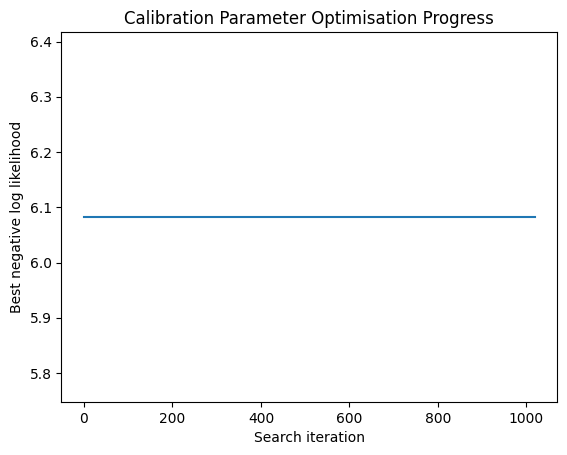

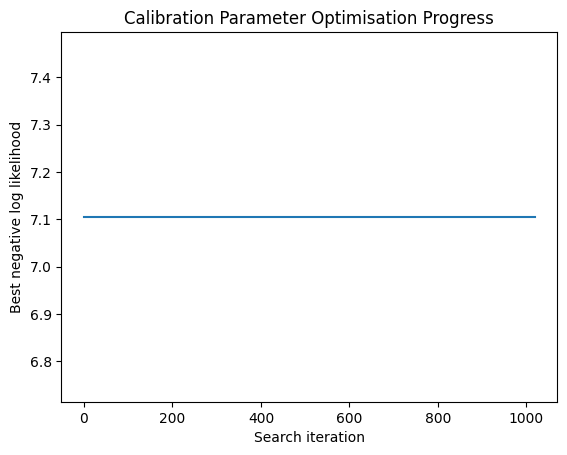

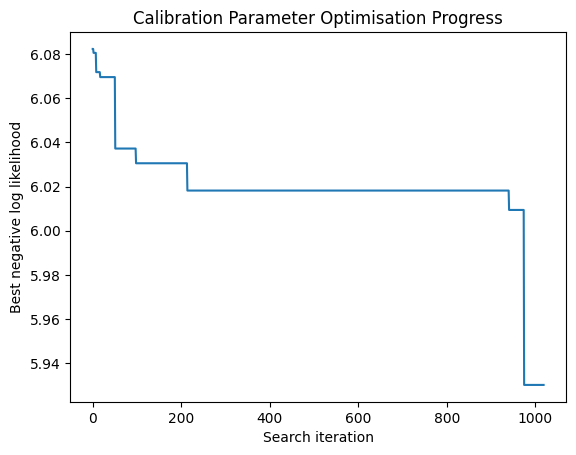

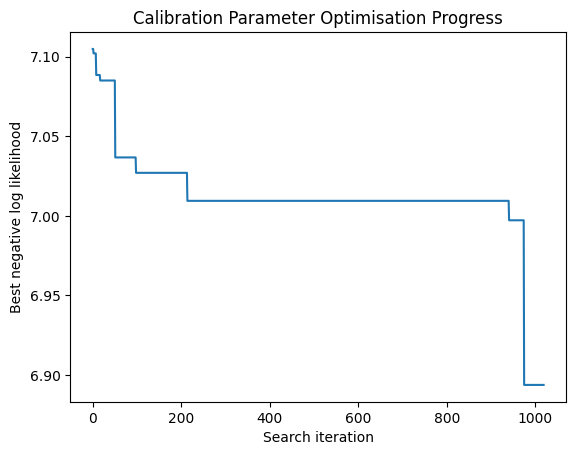

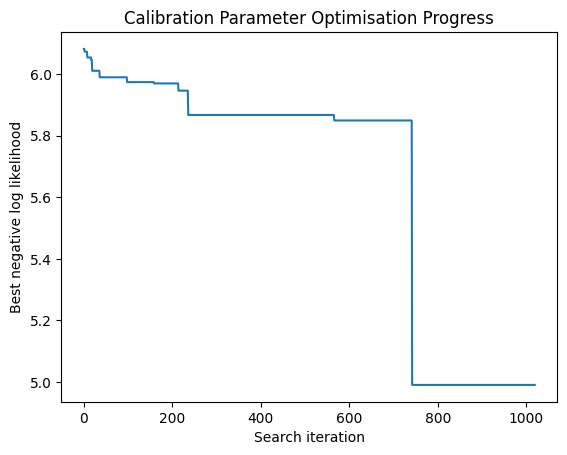

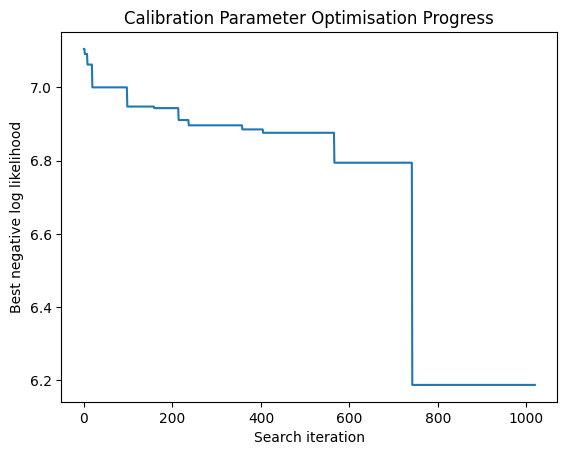

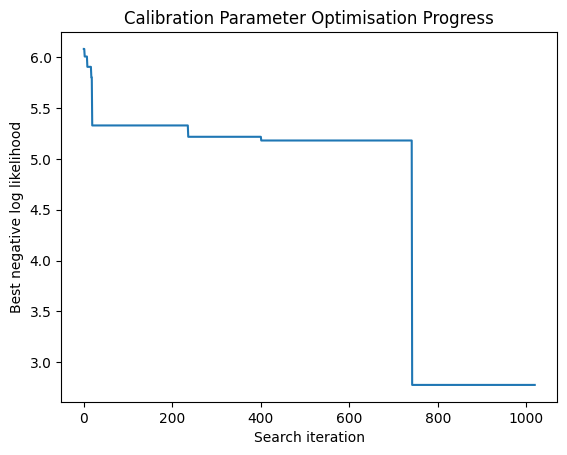

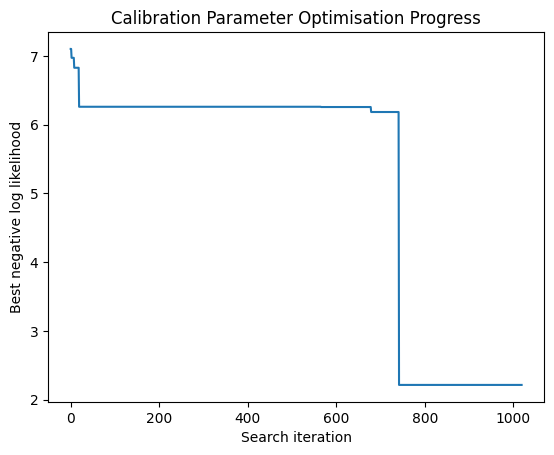

In [14]:
for num_iterations, num_approx_steps in [(1, 0), (1, 1), (1, 2),
                                         (1, 4), (2, 2), (1, 6),
                                         (4, 1), (3, 2), (5, 1)]:
    for data_noise_scale in [8.04, 8.04 / np.sqrt(sol_int_size)]:  # 8.04 Jy
        for phase_error_scale in [0.1, 1.0]:
            for gain_noise_scale in [0.1]:
                try:
                    plot(num_iterations, num_approx_steps, data_noise_scale, phase_error_scale, gain_noise_scale)
                except:
                    pass

In [80]:
i_best = jnp.argmax(log_L)
best_X = jax.tree.map(lambda x: x[i_best], X)

In [81]:
best_X

{'c_less_newton': Array(2.5198312, dtype=float32),
 'c_more_newton': Array(0.6644335, dtype=float32),
 'delta': Array(1.139877, dtype=float32),
 'mu1': Array(5.118261, dtype=float32),
 'mu_min': Array(0.045218, dtype=float32),
 'p_any_improvement': Array(0.61732614, dtype=float32),
 'p_less_newton': Array(0.8367788, dtype=float32),
 'p_more_newton': Array(0.85175663, dtype=float32),
 'p_sufficient_improvement': Array(0.8371977, dtype=float32)}

In [59]:
X['delta']

[Array(1.4901161, dtype=float32, weak_type=True),
 Array(1.8181887, dtype=float32, weak_type=True),
 Array(1.1923441, dtype=float32, weak_type=True),
 Array(1.6009336, dtype=float32, weak_type=True),
 Array(1.9476388, dtype=float32, weak_type=True),
 Array(1.2911503, dtype=float32, weak_type=True),
 Array(1.8041425, dtype=float32, weak_type=True),
 Array(1.6111803, dtype=float32, weak_type=True),
 Array(1.029642, dtype=float32, weak_type=True),
 Array(1.4101409, dtype=float32, weak_type=True),
 Array(1.719184, dtype=float32, weak_type=True),
 Array(1.21215, dtype=float32, weak_type=True),
 Array(1.5135274, dtype=float32, weak_type=True),
 Array(1.8315356, dtype=float32, weak_type=True),
 Array(1.5238087, dtype=float32, weak_type=True),
 Array(1.8153183, dtype=float32, weak_type=True),
 Array(1.2815982, dtype=float32, weak_type=True),
 Array(1.0980656, dtype=float32, weak_type=True),
 Array(1.6970501, dtype=float32, weak_type=True),
 Array(1.2938834, dtype=float32, weak_type=True),
 Arr